In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import plotly.express as px
import plotly.graph_objects as go
import os
from statistics import mean,stdev,median
from math import log
import seaborn as sns

### =========================================================================================

## FUNCTIONS

### =========================================================================================

In [2]:
def rename_df(df):
    column_rename = {}
    for i in list(df.columns):
        if '210527' in i and '.' not in i:
            if 'PBQC' in i:
                column_rename[i] = 'PBQC_'+str(i.split('_')[-1])
            else:
                if int(i.split('_')[-1]) < 8:
                    column_rename[i] = 'DEN_AdjLiver_Fasted_'+str(i.split('_')[-1])      
                elif int(i.split('_')[-1]) < 15:
                    column_rename[i] = 'DEN_Tumour_Fasted_'+str(i.split('_')[-1]) 
                elif int(i.split('_')[-1]) < 21:
                    column_rename[i] = 'nonDEN_Liver_Fasted_'+str(i.split('_')[-1])
                elif int(i.split('_')[-1]) < 30:
                    column_rename[i] = 'DEN_AdjLiver_Fed_'+str(i.split('_')[-1])
                elif int(i.split('_')[-1]) < 38:
                    column_rename[i] = 'DEN_Tumour_Fed_'+str(i.split('_')[-1])
                elif int(i.split('_')[-1]) <= 42:
                    column_rename[i] = 'nonDEN_Liver_Fed_'+str(i.split('_')[-1])
                else:
                    print(i)
        else:
            pass
    df2 = df.rename(columns=column_rename)
    selectCols = list(column_rename.values())
    selectCols.append('Compound')
    df2 = df2[selectCols]
    return df2

In [3]:
def createSampleAnnotation(df):
    sample_annot = pd.DataFrame()
    group_number = 0
    done = []
    counter = 0
    for row in df.index:
        parts = row.split('_')
        group = str('_'.join(parts[0:-1]))
        sample_annot.at[counter,'Group'] = group
        if group not in done:
            done.append(group)
            group_number += 1
            sample_annot.at[counter,'Group_number'] = group_number
        else:
            sample_annot.at[counter,'Group_number'] = group_number
        counter += 1
    return sample_annot

In [4]:
def removeUninformative(df):
    toDrop = []
    for col in df.columns:
        l = list(set(df_combined[col]))
        if len(l) == 1:
            toDrop.append(col)
    df = df.drop(toDrop,axis=1)
    return df

In [5]:
def medianScaling(df,logScale):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        medianMinPA = (df[column].loc[df[column] != 0]).median()
        df_scaled[column] = df_scaled[column]  / medianMinPA
    df_scaled = df_scaled.astype('float')
    if logScale == True:
        for column in df_scaled.columns:
            df_scaled[column] = np.log10(df_scaled[column])
    else:
        df_scaled = df_scaled
    df_scaled.replace(np.inf, 0, inplace=True)
    df_scaled.replace(-np.inf, 0, inplace=True)
    return df_scaled

### =======================================================================================

## ANALYSIS

### =======================================================================================

### Read in positive and negative ion data sheets

In [59]:
df_pos = pd.read_csv('For Frederick/Data/AA210511_A_Pos_Compound measurements.csv',skiprows=2)
df_neg = pd.read_csv('For Frederick/Data/AA210511_A_Neg_Compound measurements.csv',skiprows=2)

### Rename the dataframes to biological names and concatenate + and -

In [60]:
df_pos_parsed = rename_df(df_pos)
df_neg_parsed = rename_df(df_neg)
df_combined = pd.concat([df_pos_parsed,df_neg_parsed])

### Coefficient of variation (cv) cut-off 

In [61]:
df_pos_cv = pd.read_csv('For Frederick/Data/AA210511_A_Pos_Compound measurements_PBQCs.csv',skiprows=2)
df_neg_cv = pd.read_csv('For Frederick/Data/AA210511_A_Neg_Compound measurements_PBQCs.csv',skiprows=2)
cv_d = {**dict(zip(df_pos_cv['Compound'],df_pos_cv['Minimum CV >= 30'])),**dict(zip(df_neg_cv['Compound'],df_pos_cv['Minimum CV >= 30']))}
cv_cutoff = []
for i in cv_d:
    if cv_d[i] == 'x':
        cv_cutoff.append(str(i).strip())
df_combined = df_combined.T
df_combined.columns = df_combined.loc['Compound']
df_combined = df_combined.drop(['Compound'], axis=0)
df_combined = df_combined.drop(cv_cutoff,axis=1)

### Remove where all values the same 
### Median scale and log-scale

In [62]:
df_combined = removeUninformative(df_combined)
#df_combined = medianScaling(df_combined,logScale=True)
for index,row in df_combined.iterrows():
    for columns in df_combined.columns:
        try:
            df_combined.at[index,columns] = np.log10(df_combined.at[index,columns])
        except (ValueError, AttributeError):
            df_combined.at[index,columns] = 0
df_combined = removeUninformative(df_combined)
df_combined.replace(np.inf, 0, inplace=True)
df_combined.replace(-np.inf, 0, inplace=True)

/var/folders/zc/h_66z5bx601_njjc__92xndnxk18rv/T/ipykernel_2442/1514180393.py:6: RuntimeWarning:

divide by zero encountered in log10



### Create sample annotation dataframe

In [63]:
sample_annot = createSampleAnnotation(df_combined)
sample_annot.head()

Group  Group_number
0  PBQC           1.0
1  PBQC           1.0
2  PBQC           1.0
3  PBQC           1.0
4  PBQC           1.0

### ========================================================================================
## PLOTS
### ========================================================================================

In [64]:
d = []
for index,row in df_combined.iterrows():
    for column in df_combined.columns:
        d.append({'X' : row[column],
                  'Y' : row[column]})
toPlot = pd.DataFrame(d)

In [65]:
fig = px.scatter(toPlot,
                 x = 'X',
                 y = 'Y',
                 template = 'none')
fig.update_layout(autosize=False,height=300,width=500)
fig.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



ValueError: The condensed distance matrix must contain only finite values.

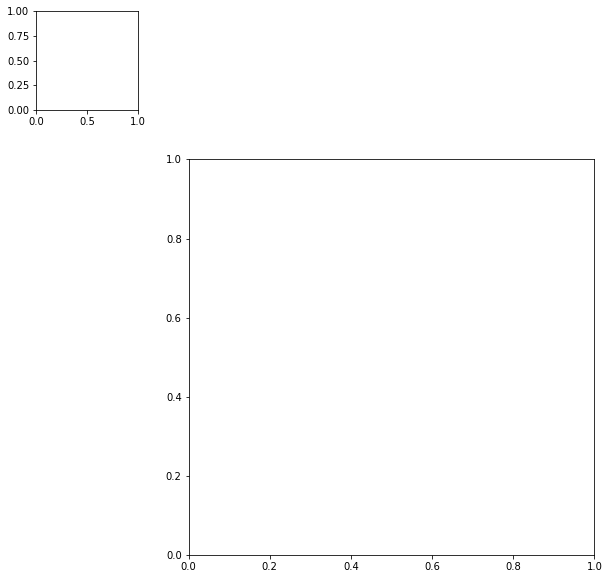

In [26]:
sns.clustermap(df_combined,cmap='vlag',center=0)

### Create PLS-DA plot using groups as clustering input

In [66]:
ncomps = 10
plsr = PLSRegression(n_components=ncomps, scale=False)
plsr.fit_transform(df_combined,sample_annot['Group_number'])
principalComponents = plsr.x_scores_
variance_in_x = np.var(plsr.x_scores_, axis = 0) 
total_variance_in_x = np.var(df_combined.to_numpy(), axis = 0)
fractions_of_explained_variance = variance_in_x / sum(total_variance_in_x)
fractions_of_explained_variance = fractions_of_explained_variance * 100
fractions_of_explained_variance = np.round_(fractions_of_explained_variance,decimals=2)

columns = []
count = 1
while count <= ncomps:
    columns.append('Component '+str(count)+' ('+str(fractions_of_explained_variance[count-1])+'%)')
    count += 1
    
principalDf = pd.DataFrame(data = principalComponents,columns=columns)
finalDf = pd.concat([principalDf, sample_annot[['Group']]], axis = 1)

In [67]:
finalDf.head()

Component 1 (9.61%)  Component 2 (6.23%)  Component 3 (4.36%)  \
0             9.374866           -33.187562            -8.137536   
1            11.953902           -28.835592            -5.982385   
2            19.183276           -25.701892            -4.964862   
3            23.526043           -18.998566            -2.555778   
4            25.684818           -17.370223            -2.118549   

   Component 4 (4.16%)  Component 5 (3.55%)  Component 6 (3.22%)  \
0             7.798704            22.096742            -0.937355   
1             7.092302            20.394865            -2.274296   
2             9.447953             5.282729             8.332254   
3             7.077059             1.064035             4.457523   
4             6.373597            -2.761860             6.995005   

   Component 7 (2.06%)  Component 8 (2.19%)  Component 9 (2.47%)  \
0            11.147176             5.506622             4.452263   
1             9.215151             7.823092           -14.585653   
2             0.723471           -10.082933             3.643006   
3            -0.379739           -16.239957             0.015179   
4            -1.509824           -18.572116             3.154833   

   Component 10 (1.59%) Group  
0             -6.327662  PBQC  
1             12.456731  PBQC  
2             -8.825720  PBQC  
3             -4.373374  PBQC  
4            -19.057543  PBQC

In [69]:
fig = px.scatter(finalDf, 
                 x = finalDf.columns[0], 
                 y = finalDf.columns[1],
                 color = 'Group',
                 template = 'none')
fig = fig.update_layout(autosize = False,
                        height = 500,
                        width = 650,
                        font_family="Arial",
                        font_color="black",
                        font_size=12)
fig.update_traces(mode='markers', 
                  marker_line_width=2, 
                  marker_size=14)
fig.write_image('Figures/PLSDA.pdf')
fig.show()

In [70]:
fig = px.scatter_3d(finalDf, x=finalDf.columns[0], y=finalDf.columns[1], z=finalDf.columns[2],
              color='Group',template='none')
fig.update_layout(autosize=False,
                  height=1000,
                  width=1000,
                  margin=dict(l=50, r=50, t=50, b=50))
fig.update_traces(mode='markers', 
                  marker_line_width=2, 
                  marker_size=10)
fig.write_html('Figures/PLSDA_3D.html')
fig.write_image('Figures/PLSDA_3D.pdf')
fig.show()